In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from scipy.stats import gennorm
from arch import arch_model 
from arch.univariate import GARCH, EGARCH, ConstantMean, SkewStudent
from copulae import NormalCopula, StudentCopula, ClaytonCopula, GumbelCopula

In [2]:
from copulae import summary

In [ ]:
pip install copulae

In [ ]:
pip install arch

In [3]:
import yfinance as yf

selected_companies = ['IBM',  'MSFT', 'MCD']

data = yf.download(selected_companies, '2017-07-01','2020-06-30' , group_by="column")

data.head()

[*********************100%***********************]  3 of 3 completed


Adj Close                              Close              \
                   IBM         MCD       MSFT         IBM         MCD   
Date                                                                    
2017-06-30  126.135643  138.243195  64.966377  153.830002  153.160004   
2017-07-03  127.570580  137.647522  64.250092  155.580002  152.500000   
2017-07-05  126.004410  138.162003  65.107742  153.669998  153.070007   
2017-07-06  124.930267  138.180038  64.627083  152.360001  153.089996   
2017-07-07  125.405861  141.050354  65.465889  152.940002  156.270004   

                             High                                Low  \
                 MSFT         IBM         MCD       MSFT         IBM   
Date                                                                   
2017-06-30  68.930000  154.500000  153.770004  69.379997  153.139999   
2017-07-03  68.169998  156.029999  153.869995  69.599998  153.520004   
2017-07-05  69.080002  155.889999  153.570007  69.440002  153.630005   
2017-07-06  68.570000  153.830002  153.460007  68.779999  152.229996   
2017-07-07  69.459999  153.490005  156.559998  69.839996  152.139999   

                                         Open                          Volume  \
                   MCD       MSFT         IBM         MCD       MSFT      IBM   
Date                                                                            
2017-06-30  152.720001  68.739998  154.279999  153.300003  68.779999  3571500   
2017-07-03  152.479996  68.019997  153.580002  153.440002  69.330002  2822500   
2017-07-05  151.990005  68.220001  155.770004  152.820007  68.260002  3564400   
2017-07-06  152.330002  68.120003  153.360001  152.699997  68.269997  2757500   
2017-07-07  153.149994  68.699997  152.619995  153.369995  68.699997  2460100   

                               
                MCD      MSFT  
Date                           
2017-06-30  2508200  24161100  
2017-07-03  1100700  16165500  
2017-07-05  2497300  21176300  
2017-07-06  2019800  21117600  
2017-07-07  4117800  16878300

In [4]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(754, 3)


,IBM,MCD,MSFT
Date,,,
2017-06-30,126.135643,138.243195,64.966377
2017-07-03,127.570580,137.647522,64.250092
2017-07-05,126.004410,138.162003,65.107742
2017-07-06,124.930267,138.180038,64.627083
2017-07-07,125.405861,141.050354,65.465889


In [5]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)
PeriodIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
             '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
             '2017-07-13', '2017-07-14',
             ...
             '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
             '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
             '2020-06-26', '2020-06-29'],
            dtype='period[D]', name='Date', length=754)


In [6]:
returns = prices.pct_change().dropna()

returns.head()

,IBM,MCD,MSFT
Date,,,
2017-07-03,0.011376,-0.004309,-0.011025
2017-07-05,-0.012277,0.003738,0.013349
2017-07-06,-0.008525,0.000131,-0.007383
2017-07-07,0.003807,0.020772,0.012979
2017-07-10,0.003138,-0.004800,0.007486


In [7]:
w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

w_temp = 1 / prices.iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns.values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

IBM     0.259473
MCD     0.236748
MSFT    0.503780
Name: 2017-06-30, dtype: float64
IBM     0.259473
MCD     0.236748
MSFT    0.503780
Name: 2017-06-30, dtype: float64


# Historical simulation

In [26]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

def calculate_ES_HS(ret, alpha=0.05):
    VaR = ret.quantile(alpha)
    return(ret[ret < VaR].mean())

def make_dummy_student_simulations(returns, n_samples=10**3):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = ss.t.fit(returns[col])
        return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations

def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [68]:
VaR_HS = calc_VaR(returns[selected_companies], calculate_VaR_HS, w_temp)
ES_HS = calc_VaR(returns[selected_companies], calculate_ES_HS, w_temp)

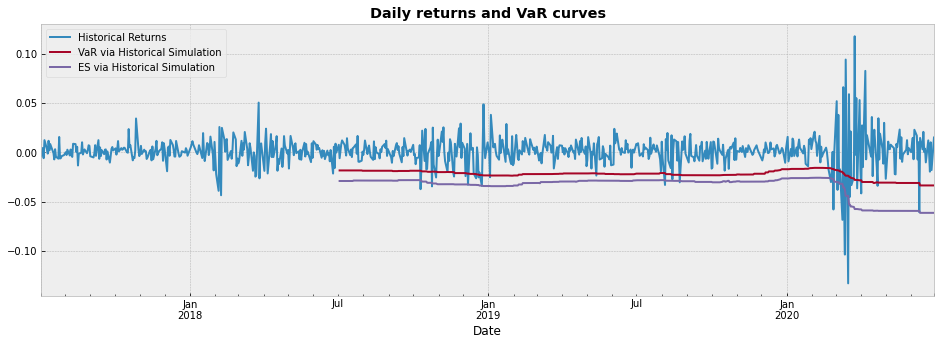

In [80]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_HS.plot()
ES_HS.plot()


plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
             'VaR via Historical Simulation', 'ES via Historical Simulation'])

plt.show()

# Multivariate normal 

In [81]:
def make_mult_normal_simulations(returns, n_samples=10**3):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [82]:
VaR_multy_normal = calc_VaR(returns[selected_companies], make_mult_normal_simulations, w_temp)

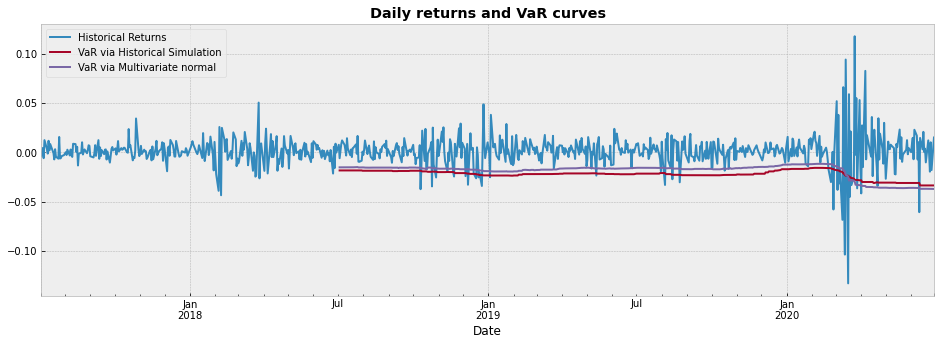

In [84]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_HS.plot()
VaR_multy_normal.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
             'VaR via Historical Simulation',
           'VaR via Multivariate normal'])

plt.show()

# Backtesting

In [8]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'
    
def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [87]:
backtest_VaR(portfolio_real_returns_selected, VaR_HS, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_multy_normal, 1-alpha)

Backtesting calculate_VaR_HS:
The proportion of hits is 6.39% instead of expected 5.0%
Two-sided p-val 0.151, one-sided: 0.0963
green zone

Backtesting make_mult_normal_simulations:
The proportion of hits is 8.18% instead of expected 5.0%
Two-sided p-val 0.00271, one-sided: 0.0016
yellow zone



HS is better

# GMM model

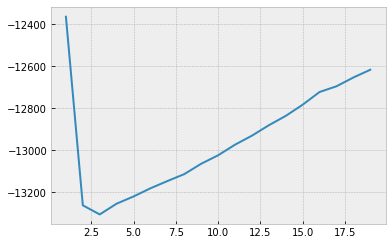

In [11]:
n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=42) for n in n_components]
bics = [model.fit(returns.values).bic(returns.values) for model in models]
plt.plot(n_components, bics);

In [12]:
best_n_component = bics.index(min(bics))
best_n_component

2

In [13]:
def make_gmm_simulations(returns, n_components= best_n_component, n_samples=10**3):

    gmm = GaussianMixture(n_components= best_n_component, covariance_type='full', n_init=3, random_state=42) # full spherical
    gmm.fit(returns.values)

    return_simulations = gmm.sample(n_samples=n_samples)[0]

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [14]:
VaR_gmm_best = calc_VaR(returns[selected_companies], make_gmm_simulations, w_temp)

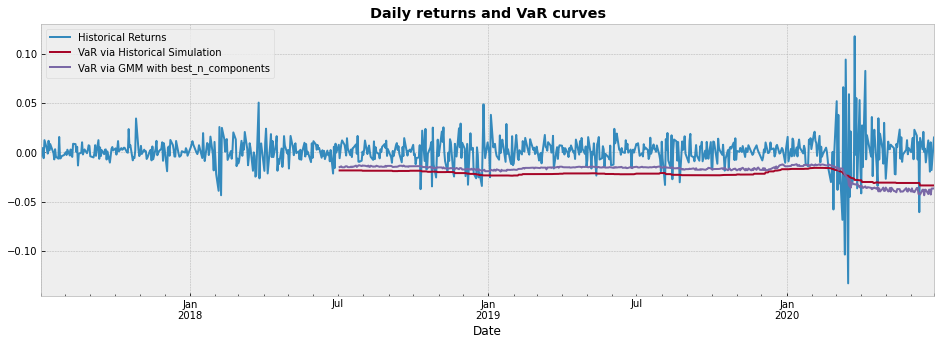

In [15]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_HS.plot()
VaR_gmm_best.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via GMM with best_n_components'])

plt.show()

# Copula+GARCH model

In [9]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [20]:
cop = NormalCopula(dim = cdfs.shape[1])
cop.fit(cdfs)

              IBM         MCD        MSFT
count  753.000000  753.000000  753.000000
mean     0.500000    0.500000    0.500000
std      0.288484    0.288484    0.288484
min      0.001326    0.001326    0.001326
25%      0.250663    0.250663    0.250663
50%      0.500000    0.500000    0.500000
75%      0.749337    0.749337    0.749337
max      0.998674    0.998674    0.998674


In [21]:
cop.summary()

1.000000,0.400999,0.581501
0.400999,1.000000,0.461236
0.581501,0.461236,1.000000


In [44]:
def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()
        
    am = arch_model(ret * scaling_const,
                    mean='Constant', lags=1, 
                    vol='Garch', p=1, o=0, q=1,
                    dist=dist)
    res = am.fit(update_freq=0)

    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res, scaling_const

def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
 
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [45]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    cop = copula_func(dim = returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
            cdfs[col] = cdf

    cop.fit(cdfs)
    cop.summary()

    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    

    return_simulations = copula_simulations.copy()
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)

    return return_simulations

In [46]:
def make_copula_simulation_wrap(returns):
    return_simulations = make_copula_simulation(returns, NormalCopula,
                                            n_samples=10**3, univariate_dist='garch')
    
    return return_simulations

In [ ]:
VaR_copulanorm_garch = calc_VaR(returns, make_copula_simulation_wrap, w_temp)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 881.0989797641553
            Iterations: 32
            Function evaluations: 235
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.9367188486797
            Iterations: 42
            Function evaluations: 316
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.5685798070299
            Iterations: 23
            Function evaluations: 170
            Gradient evaluations: 23
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.2332070066117
            Iterations: 23
            Function evaluations: 170
            Gradient evaluations: 23
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 882.2167969716345
            Iterations: 36
            Function evaluations: 262
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.5801190361302
            Iterations: 38
            Function evaluations: 287
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 882.4861542657012
            Iterations: 38
            Function evaluations: 289
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: 905.5708241618705
            Iterations: 30
            Function evaluations: 230
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: 895.6924027284398
            Iterations: 20
            Function evaluations: 148
            Gradient evaluations: 20
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 902.8722117083115
            Iterations: 29
            Function evaluations: 218
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.9269138702692
            Iterations: 21
            Function evaluations: 156
            Gradient evaluations: 21
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 885.975618454738
            Iterations: 25
            Function evaluations: 186
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 894.5102817190905
            Iterations: 22
            Function evaluations: 162
            Gradient evaluations: 22
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 887.7093348300946
            Iterations: 34
            Function evaluations: 249
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.4047733347268
            Iterations: 29
            Function evaluations: 218
            Gradient evaluati

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 887.2343686559298
            Iterations: 30
            Function evaluations: 219
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.7732037492397
            Iterations: 28
            Function evaluations: 214
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.1447196250577
            Iterations: 19
            Function evaluations: 142
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 884.8833632219673
            Iterations: 35
            Function evaluations: 256
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.790710655858
            Iterations: 29
            Function evaluations: 218
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 897.4894038548352
            Iterations: 20
            Function evaluations: 147
            Gradient evaluations: 20
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.8851421505718
            Iterations: 24
            Function evaluations: 175
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.3213192780586
            Iterations: 20
            Function evaluations: 145
            Gradient evaluations: 20
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 888.2948901852471
            Iterations: 30
            Function evaluations: 220
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.3000765477245
            Iterations: 31
            Function evaluations: 229
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.580172888005
            Iterations: 25
            Function evaluations: 188
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.0831631132833
            Iterations: 22
            Function evaluations: 163
            Gradient evaluations: 22
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.5387575165317
            Iterations: 26
            Function evaluations: 193
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 901.4782039931924
            Iterations: 20
            Function evaluations: 147
            Gradient evaluations: 20
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 898.3069723774765
            Iterations: 20
            Function evaluations: 151
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 894.724523770366
            Iterations: 22
            Function evaluations: 167
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.0865319994865
            Iterations: 25
            Function evaluations: 188
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.8008534115008
            Iterations: 16
            Function evaluations: 119
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 901.0704379789709
            Iterations: 17
            Function evaluations: 126
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 898.0816472358082
            Iterations: 22
            Function evaluations: 165
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 905.2734486774149
            Iterations: 23
            Function evaluations: 174
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.624456229014
            Iterations: 26
            Function evaluations: 199
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.9747677930686
            Iterations: 16
            Function evaluations: 121
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 900.6304650360503
            Iterations: 22
            Function evaluations: 167
            Gradient evaluatio

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.8414096586974
            Iterations: 22
            Function evaluations: 167
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 905.0823659541824
            Iterations: 27
            Function evaluations: 203
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.5914799032221
            Iterations: 18
            Function evaluations: 132
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 910.1058278589312
            Iterations: 23
            Function evaluations: 173
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.1120904631118
            Iterations: 14
            Function evaluations: 104
            Gradient evaluations: 14
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.4839503805545
            Iterations: 25
            Function evaluations: 189
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 905.1607432952637
            Iterations: 17
            Function evaluations: 125
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 908.8074403002
            Iterations: 22
            Function evaluations: 167
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 914.7676613402285
            Iterations: 21
            Function evaluations: 156
            Gradient evaluations

Optimization terminated successfully    (Exit mode 0)
            Current function value: 908.2976591104159
            Iterations: 19
            Function evaluations: 143
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.5372167770105
            Iterations: 22
            Function evaluations: 163
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.7271287848705
            Iterations: 16
            Function evaluations: 120
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.0308870485347
            Iterations: 21
            Function evaluations: 161
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.6132147211592
            Iterations: 16
            Function evaluations: 117
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 902.0238208325386
            Iterations: 16
            Function evaluations: 122
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 901.1200805238943
            Iterations: 19
            Function evaluations: 144
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 916.1123428992113
            Iterations: 27
            Function evaluations: 207
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.0428193487473
            Iterations: 17
            Function evaluations: 128
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.06172991527
            Iterations: 19
            Function evaluations: 142
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 916.8182715557231
            Iterations: 24
            Function evaluations: 180
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.1565938162948
            Iterations: 17
            Function evaluations: 126
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 894.7398263916125
            Iterations: 15
            Function evaluations: 116
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 918.1342681596108
            Iterations: 21
            Function evaluations: 155
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.0914308893691
            Iterations: 17
            Function evaluations: 126
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.458791655575
            Iterations: 18
            Function evaluations: 137
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 891.2342613783535
            Iterations: 20
            Function evaluations: 152
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 916.8439035181038
            Iterations: 19
            Function evaluations: 139
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 889.2251197262651
            Iterations: 17
            Function evaluations: 129
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 915.57462712995
            Iterations: 19
            Function evaluations: 141
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.7532214513442
            Iterations: 16
            Function evaluations: 120
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.9

Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.3978165490909
            Iterations: 17
            Function evaluations: 127
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 884.9933725557837
            Iterations: 18
            Function evaluations: 137
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 912.152576552272
            Iterations: 14
            Function evaluations: 108
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 887.3312098607771
            Iterations: 18
            Function evaluations: 138
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 911.6668612380524
            Iterations: 23
            Function evaluations: 178
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 902.5764638980461
            Iterations: 15
            Function evaluations: 114
            Gradient evaluations: 15
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 918.2464806160351
            Iterations: 20
            Function evaluations: 150
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.2538455564031
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 887.3720056074296
            Iterations: 18
            Function evaluations: 137
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 891.3041659711985
            Iterations: 17
            Function evaluations: 130
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.1077243779862
            Iterations: 16
            Function evaluations: 121
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.144816982178
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 908.5636268341468
            Iterations: 16
            Function evaluations: 120
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.586798871175
            Iterations: 18
            Function evaluations: 137
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 914.5100177720119
            Iterations: 15
            Function evaluations: 113
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 897.0631920158851
            Iterations: 19
            Function evaluations: 145
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 919.2378936080827
            Iterations: 14
            Function evaluations: 108
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 910.889568714118
            Iterations: 16
            Function evaluations: 118
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.2401661049078
            Iterations: 14
            Function evaluations: 109
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 911.969852968748
            Iterations: 17
            Function evaluations: 125
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 895.59648450639
            Iterations: 18
            Function evaluations: 138
            Gradient evaluations

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 894.5798429625713
            Iterations: 18
            Function evaluations: 135
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 918.0225579782534
            Iterations: 15
            Function evaluations: 111
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.35614531849
            Iterations: 19
            Function evaluations: 141
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.3248449329494
            Iterations: 19
            Function evaluations: 142
            Gradient evaluations: 19
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 891.6270626132839
            Iterations: 19
            Function evaluations: 145
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.3059269337687
            Iterations: 14
            Function evaluations: 108
            Gradient evaluati

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.179458550715
            Iterations: 19
            Function evaluations: 145
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 916.8165966597246
            Iterations: 13
            Function evaluations: 98
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.1183395340237
            Iterations: 18
            Function evaluations: 133
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.9172793937735
            Iterations: 20
            Function evaluations: 152
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.1254445977247
            Iterations: 12
            Function evaluations: 92
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 908.4947275875402
            Iterations: 18
            Function evaluations: 133
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 910.3314680982974
            Iterations: 21
            Function evaluations: 159
            Gradient evaluations: 21
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.3579635496496
            Iterations: 27
            Function evaluations: 204
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.640137885528
            Iterations: 12
            Function evaluations: 92
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 900.8756905349877
            Iterations: 51
            Function evaluations: 381
            Gradient evaluations: 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.541832293777
            Iterations: 10
            Function evaluations: 82
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 911.3391697563658
            Iterations: 18
            Function evaluations: 137
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.9

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 902.3126522922682
            Iterations: 47
            Function evaluations: 351
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: 919.2188108205207
            Iterations: 12
            Function evaluations: 93
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 912.6931180066954
            Iterations: 16
            Function evaluations: 117
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 918.6354106200876
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 913.9083154070879
            Iterations: 18
            Function evaluations: 134
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 901.3269813823774
            Iterations: 18
            Function evaluations: 136
            Gradient evaluatio

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 897.9811811618454
            Iterations: 23
            Function evaluations: 172
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 919.9586605319375
            Iterations: 15
            Function evaluations: 114
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 913.28123762068
            Iterations: 18
            Function evaluations: 135
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.6281505226768
            Iterations: 17
            Function evaluations: 129
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 925.0186418655958
            Iterations: 16
            Function evaluations: 122
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 911.9005009701963
            Iterations: 19
            Function evaluations: 142
            Gradient evaluations: 19
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 906.0948769344144
            Iterations: 25
            Function evaluations: 188
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.1944505944816
            Iterations: 15
            Function evaluations: 115
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 917.161836383664
            Iterations: 18
            Function evaluations: 135
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 902.2394637126326
            Iterations: 15
            Function evaluations: 114
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.2313055178555
            Iterations: 25
            Function evaluations: 182
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 912.4778547780626
            Iterations: 18
            Function evaluations: 135
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.1160490236912
            Iterations: 17
            Function evaluations: 132
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 923.4421212393202
            Iterations: 29
            Function evaluations: 212
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 910.9865067748736
            Iterations: 17
            Function evaluations: 130
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.6603897378542
            Iterations: 19
            Function evaluations: 141
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.2102094096651
            Iterations: 27
            Function evaluations: 196
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.511861904704
            Iterations: 18
            Function evaluations: 134
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.6888405430907
            Iterations: 21
            Function evaluations: 153
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.0468825920444
            Iterations: 18
            Function evaluations: 133
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 895.2094584996702
            Iterations: 19
            Function evaluations: 142
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.8247360526934
            Iterations: 17
            Function evaluations: 126
            Gradient evaluations: 17
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 895.163950191567
            Iterations: 20
            Function evaluations: 149
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 921.3226071609472
            Iterations: 30
            Function evaluations: 219
            Gradient evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 905.4723990204513
            Iterations: 19
            Function evaluations: 144
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.6946332559064
            Iterations: 22
            Function evaluations: 160
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 923.566976397808
            Iterations: 19
            Function evaluations: 140
            Gradient evaluations: 19
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.6300731808033
            Iterations: 28
            Function evaluations: 206
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.3179950986942
            Iterations: 18
            Function evaluations: 132
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.0645921232979
            Iterations: 19
            Function evaluations: 142
            Gradient evaluati

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.17692678764
            Iterations: 21
            Function evaluations: 157
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 919.8449784051522
            Iterations: 28
            Function evaluations: 205
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.3977262120662
            Iterations: 19
            Function evaluations: 140
            Gradient evaluation

Optimization terminated successfully    (Exit mode 0)
            Current function value: 913.8930821118039
            Iterations: 21
            Function evaluations: 153
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.4060798461296
            Iterations: 15
            Function evaluations: 112
            Gradient evaluations: 15
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.6299197086992
            Iterations: 25
            Function evaluations: 185
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 855.2761577634091
            Iterations: 23
            Function evaluations: 170
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 844.7508527841203
            Iterations: 16
            Function evaluations: 118
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 864.2910145363307
            Iterations: 16
            Function evaluations: 119
            Gradient evaluations: 16
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 749.7139681032775
            Iterations: 12
            Function evaluations: 92
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 804.864913273862
            Iterations: 15
            Function evaluations: 110
            Gradient evaluations: 15
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 832.7765332544219
            Iterations: 16
            Function evaluations: 122
            Gradient evaluation

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 827.9463837321382
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 755.8858628100377
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 808.6656900869075
            Iterations: 15
            Function evaluations: 110
            Gradient evaluati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 830.4260155083653
            Iterations: 15
            Function evaluations: 113
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 763.9549976813704
            Iterations: 12
            Function evaluations: 93
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 816.0898079025455
            Iterations: 18
            Function evaluations: 134
            Gradient evaluations: 18
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288101
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 817.2775419323857
            Iterations: 24
            Function evaluations: 182
            Gradient evaluations: 24
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288042
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.960474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 836.1611723961796
            Iterations: 12
            Function evaluations: 91
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 767.0458539611275
            Iterations: 13
            Function evaluations: 99
            Gradient evaluation

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288095
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.978261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 836.9799846061009
            Iterations: 12
            Function evaluations: 94
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 773.2290657244109
            Iterations: 13
            Function evaluations: 99
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 816.3043052388178
            Iterations: 21
            Function evaluations: 169
            Gradient evaluation

In [ ]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()

VaR_copulanorm_garch.plot()
VaR_HS.plot()
VaR_gmm_best.plot()

plt.title("VaR levels", weight="bold")

plt.legend(['Daily returns and VaR curves',
            'VaR_copulanorm_garch','VaR via Historical Simulation',
           'VaR via Multivariate normal'])

plt.show()

In [50]:
alpha = 0.05
backtest_VaR(portfolio_real_returns_selected, VaR_HS, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_multy_normal, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_gmm_best, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_copulanorm_garch, 1-alpha)

Backtesting calculate_VaR_HS:
The proportion of hits is 6.39% instead of expected 5.0%
Two-sided p-val 0.151, one-sided: 0.0963
green zone



NameError: name 'VaR_multy_normal' is not defined